# Create Records  Tutorial

In [67]:
cd /home/

/home


In [68]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from core.data import create_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
metadata = pd.read_csv('./data/raw_data/ztf_forced/metadata.csv')
metadata = metadata.replace({'EB/EW':'EB&EW', 'CV/Nova':'CV&Nova'})
metadata.sample(1)

,oid,ra,dec,submitter,alerceclass,partition
47376,ZTF18aaaaras,104.102036,42.292021,ireyes,EA,training_3


In [70]:
metadata['alerceclass'].unique()

array(['AGN', 'Blazar', 'CVNova', 'Ceph', 'DSCT', 'EA', 'EBEW', 'LPV',
       'Periodic-Other', 'QSO', 'RRLab', 'RRLc', 'RSCVn', 'SNIa', 'YSO',
       'nonSNIa'], dtype=object)

In [71]:
transient = ['SNIa', 'nonSNIa']#['SNIa', 'SNIbc', 'SNII', 'SNIIn', 'SNIIb', 'SLSN', 'TDE']
stochastic = ['QSO', 'AGN', 'Blazar', 'CVNova', 'YSO'] 
periodic = ['LPV', 'RSCVn', 'Ceph', 'EA', 'EBEW', 'RRLc', 'RRLab', 'DSCT', 'Periodic-Other']

In [72]:
change = {'SNIa':'Transient', 'nonSNIa':'Transient', 'QSO':'Stochastic', 'AGN':'Stochastic', 
 'Blazar':'Stochastic', 'CVNova':'Stochastic', 'YSO':'Stochastic', 
 'LPV':'Periodic', 'RSCVn':'Periodic', 'Ceph':'Periodic', 'EA':'Periodic', 
 'EBEW':'Periodic', 'RRLc':'Periodic', 'RRLab':'Periodic', 'DSCT':'Periodic', 'Periodic-Other':'Periodic'}

In [73]:
metadata['alerceclass'] = metadata['alerceclass'].replace(change)

In [74]:
class_names =list( metadata['alerceclass'].unique())
class_names

['Stochastic', 'Periodic', 'Transient']

# Reading observations

In [12]:
%%time
observations = pd.read_csv('./data/raw_data/ztf_forced/detections.csv')

CPU times: user 8.53 s, sys: 1.67 s, total: 10.2 s
Wall time: 10.6 s


In [13]:
observations.sample(2)

,oid,index,forcediffimflux,forcediffimfluxunc,forcediffimsnr,mjd,fid,flux_diff_ujy,sigma_flux_diff_ujy
3996403,ZTF18aaqflxt,196,-336.162073,32.844742,-11.385121,58249.350093,1,-36.020415,3.519378
6863193,ZTF18ablhuip,383,-522.742562,36.024801,-16.141395,59380.192245,2,-73.061379,5.035024


# Writting records

In [77]:
test_df = metadata[metadata['partition'] == 'test']

In [100]:
%%time
for fold_n in range(1):
    test_df.to_csv('data/records/forced/fold_{}/test_samples.csv'.format(fold_n), index=False)
    
    create_dataset(metadata[metadata['partition'] == 'training_{}'.format(fold_n)], 
                   observations,
                   target='data/records/forced/fold_{}/train'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)
    
    create_dataset(metadata[metadata['partition'] == 'validation_{}'.format(fold_n)], 
                   observations,
                   target='data/records/forced/fold_{}/val'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)
    
    create_dataset(test_df, 
                   observations,
                   target='data/records/forced/fold_{}/test'.format(fold_n),
                   n_jobs = 8,
                   unique_labels=class_names)

[INFO] Preprocessing lighcurves...


100%|███████████████████████████████████| 14481/14481 [00:08<00:00, 1748.46it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1609/1609 [00:00<00:00, 1839.63it/s]


[INFO] Preprocessing lighcurves...


100%|█████████████████████████████████████| 1600/1600 [00:00<00:00, 1846.21it/s]

CPU times: user 21.5 s, sys: 2.22 s, total: 23.7 s
Wall time: 29 s


# Reading records

In [115]:
from core.data import load_records
import numpy as np
import matplotlib.pyplot as plt

In [116]:
test_df = pd.read_csv('./data/records/forced/fold_0/test_samples.csv')
num_classes = len(metadata['alerceclass'].unique())

In [117]:
dataset = load_records('./data/records/forced/fold_0/test/', batch_size=256, 
                       max_obs=200, num_classes=num_classes, 
                       sampling=False, shuffle=True)

2021-11-17 19:14:20.967828: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


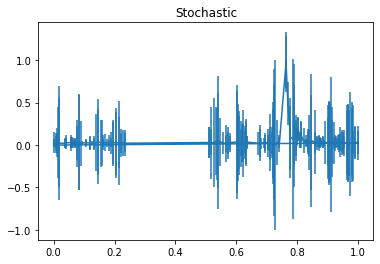

In [123]:
for x, y in dataset:
    sample = x['input'][0]
    plt.errorbar(sample[:, 0], sample[:, 1], yerr=sample[:, 2])
    plt.title('{}'.format(class_names[np.argmax(y[0], 0)]))
    break